<img src='images/pandaearth.jpg' align='center' width="500x">

# Аналитика продаж в pandas

В этот раз мы с вами рассмотрим реальный продуктовый кейс по анализу продаж в некотором онлайн магазине. Поотвечаем на бизнес-вопросы, которые часто волнуют аналитиков в крупных компаниях.

In [45]:
import pandas as pd 
import numpy as np
import scipy.stats as sts

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set_theme(style="whitegrid", palette="muted")

### Описание данных

У вас есть данные о продажах в некотором интернет-магазине техники. 

- **`Order ID`** – айдишник заказа;
    - _айдишник является уникальным номером для каждого созданного заказа и определяется в момент создания заказа_
- **`Product`** – товар, который пользователь добавил в свой заказ;
    - _обратите внимание, что в одном заказе может быть несколько товаров_
- **`Quantity Ordered`** – кол-во определенного товара в заказе;
- **`Price Each`** – цена одного определенного товара в заказе (в долл.);
- **`Order Date`** – дата создания заказа;
- **`Purchase Address`** – адрес доставки заказа;
- **`User ID`** – айдишник пользователя, сделавшего заказ.
    - _при этом один заказ относится только к одному пользователю, то есть связка Order ID – User ID является уникальной_

In [5]:
df = pd.read_csv('data/sales_data.csv')

In [6]:
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,User ID
0,165079,AA Batteries (4-pack),1,3.84,03/24/19 19:17,"953 Johnson St, Boston, MA 02215",14152.0
1,289147,Macbook Pro Laptop,1,1700,11/29/19 07:25,"826 13th St, Los Angeles, CA 90001",49793.0
2,293940,AA Batteries (4-pack),1,3.84,11/28/19 12:00,"543 Main St, San Francisco, CA 94016",4748.0
3,288851,Lightning Charging Cable,1,14.95,11/02/19 18:32,"601 Maple St, Los Angeles, CA 90001",73924.0
4,239927,Apple Airpods Headphones,1,150,08/09/19 20:35,"88 Maple St, Los Angeles, CA 90001",23344.0


### Предварительный анализ

Перед тем, как приступать к решению конкретной задачи, нужно посмотреть на ваши данные. Понять, каким образом они устроены, какие в целом признаки у вас есть, правильно ли эти данные подгрузились, есть ли у вас пропуски, какой формат имеет каждая колонка и так далее. 

**Что там по кол-ву наблюдений?**

In [7]:
df.shape

(187205, 7)

**Что там с пропусками?**

In [8]:
df.isnull().sum()

Order ID            545
Product             545
Quantity Ordered    545
Price Each          545
Order Date          545
Purchase Address    545
User ID             545
dtype: int64

> Видим, что в данных есть пропуски. Причем кажется, что по каждой колонке это одни и те же строки. В таком случае мы можем просто их удалить.

In [9]:
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

In [10]:
# кол-во колонок уменьшилось ровно на 545
df.shape

(186660, 7)

**Что там по формату колонок?**

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186660 entries, 0 to 186659
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186660 non-null  object
 1   Product           186660 non-null  object
 2   Quantity Ordered  186660 non-null  object
 3   Price Each        186660 non-null  object
 4   Order Date        186660 non-null  object
 5   Purchase Address  186660 non-null  object
 6   User ID           186660 non-null  object
dtypes: object(7)
memory usage: 10.0+ MB


> Видим, что все колонки имеют тип данных `object` – это не очень хорошо, ведь мы явно знаем, что `Order ID`, `User ID` и `Quantity Ordered` должны иметь тип `int`, а цена – `float`. При этом в pandas есть специальный формат для даты и по-хорошему нужно им тоже воспользоваться для колонки `Order Date`. Скорей всего такое произошло из-за пропусков, либо из-за других проблем в колонках. Нужно будет найти их и после этого подкорректировать форматы колонок.

In [12]:
# пробуем перевести колонку Order ID в int, получаем ошибку и разбираемся почему...
df['Order ID'].astype('int64')

ValueError: invalid literal for int() with base 10: 'Order ID'

In [13]:
# в колонках почему-то лежат их названия, надо бы их выкинуть
df[~df['Order ID'].str.isdigit()]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,User ID
157,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,User ID
679,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,User ID
814,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,User ID
897,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,User ID
1071,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,User ID
...,...,...,...,...,...,...,...
184639,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,User ID
185261,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,User ID
186155,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,User ID
186565,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,User ID


In [14]:
# оставляем только хорошие наблюдения
df = df[df['Order ID'].str.isdigit()]
df.reset_index(drop=True, inplace=True)

In [15]:
# теперь пробуем перевести тип колонок еще раз
df[['Order ID', 'Quantity Ordered', 'User ID']] = df[['Order ID', 'Quantity Ordered', 'User ID']].astype('float64')
df[['Order ID', 'Quantity Ordered', 'User ID']] = df[['Order ID', 'Quantity Ordered', 'User ID']].astype('int64')
df['Price Each'] = df['Price Each'].astype('float64')

Теперь разберемся с датой:

In [16]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [17]:
# посмотрим еще раз на тип колонок
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185950 entries, 0 to 185949
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185950 non-null  int64         
 1   Product           185950 non-null  object        
 2   Quantity Ordered  185950 non-null  int64         
 3   Price Each        185950 non-null  float64       
 4   Order Date        185950 non-null  datetime64[ns]
 5   Purchase Address  185950 non-null  object        
 6   User ID           185950 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 9.9+ MB


Отлично!

**Что там с распределением признаков?**

Кол-во заказов

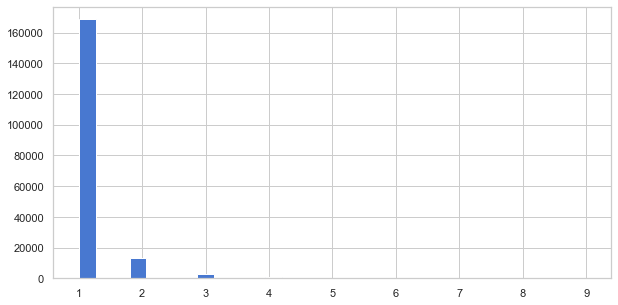

In [18]:
plt.figure(figsize=(10, 5))
df['Quantity Ordered'].hist(bins=30);

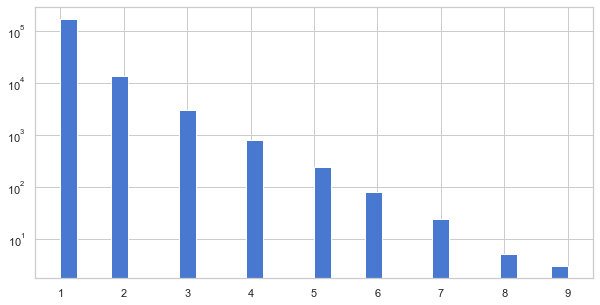

In [19]:
plt.figure(figsize=(10, 5))
df['Quantity Ordered'].hist(bins=30, log=True);

> Похоже на Пуассона

Стоимость заказа

In [20]:
# готовим данные для графика
df['GMV'] = df['Price Each'] * df['Quantity Ordered']
gb = df.groupby('Order ID')['GMV'].sum()

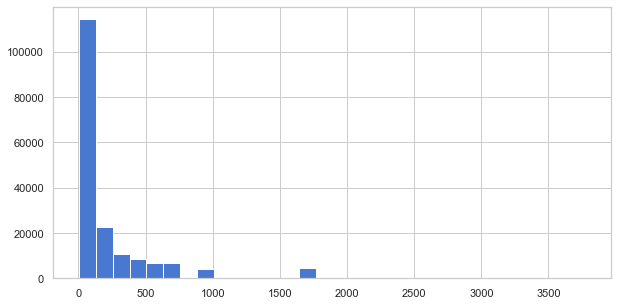

In [21]:
plt.figure(figsize=(10, 5))
gb.hist(bins=30);

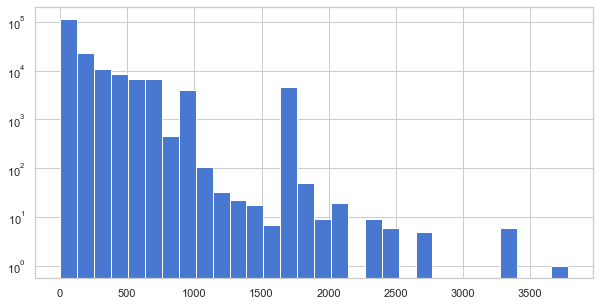

In [22]:
plt.figure(figsize=(10, 5))
gb.hist(bins=30, log=True);

> Есть явные выбросы в районе $\$2000$ и выше. Не будем пока их удалять, но будем держать в голове.

С помощью метода `.value_counts()` можно еще смотреть на распределение значений в категориальных признаках, например, можем посмотреть, какие товары чаще всего заказывали:

In [23]:
df['Product'].value_counts()

USB-C Charging Cable          21903
Lightning Charging Cable      21658
AAA Batteries (4-pack)        20641
AA Batteries (4-pack)         20577
Wired Headphones              18882
Apple Airpods Headphones      15549
Bose SoundSport Headphones    13325
27in FHD Monitor               7507
iPhone                         6842
27in 4K Gaming Monitor         6230
34in Ultrawide Monitor         6181
Google Phone                   5525
Flatscreen TV                  4800
Macbook Pro Laptop             4724
ThinkPad Laptop                4128
20in Monitor                   4101
Vareebadd Phone                2065
LG Washing Machine              666
LG Dryer                        646
Name: Product, dtype: int64

На первых этапах не стоит сильно упарываться в предварительный анализ, пора переходить к задачам.

### Кейс №1: Реклама и пиар

Предположим, что перед нами стоит задача привлечения новых пользователей и удержание существующих. Для этого мы собираемся, во-первых, устраивать различные промоакции в периоды падения активности, чтобы стимулировать пользователей покупать товары, а во-вторых, запускать крупные рекламные кампании, наоборот, в период высокой активности пользователей, чтобы пользователи покупали товары именно в нашем интернет-магазине. 

__Как определить период, когда следует запускать разного рода акции?__

Обычно, в таких задачах _нету единственного правильного решения_. Вам нужно накидать возможные гипотезы и варианты, а затем обсудить минусы и плюсы каждого подхода. 

При этом нужно всегда отталкиваться от данных, которые у вас есть, и от сроков, которые вы готовы потратить на эту задачу:
- можно построить супер новороченный предсказательный алгоритм и потратить на него полгода, а можно пару часов посидеть в пандасе и уже придумать вполне себе хорошее решение

_Одно из возможных решений:_
1. Посмотреть на динамику кол-ва заказов по дням, возможно увидим сезонность.
2. Посмотреть распределение выручки от заказов по месяцам.
3. Посмотреть, в какое время суток чаще всего создают заказ.

1. Динамика кол-ва заказов по дням

In [24]:
# оставляем только дату (без времени)
df['Order Time'] = df['Order Date']
df['Order Date'] = df['Order Date'].dt.date

In [25]:
bydays = df.groupby('Order Date')['Order ID'].nunique()

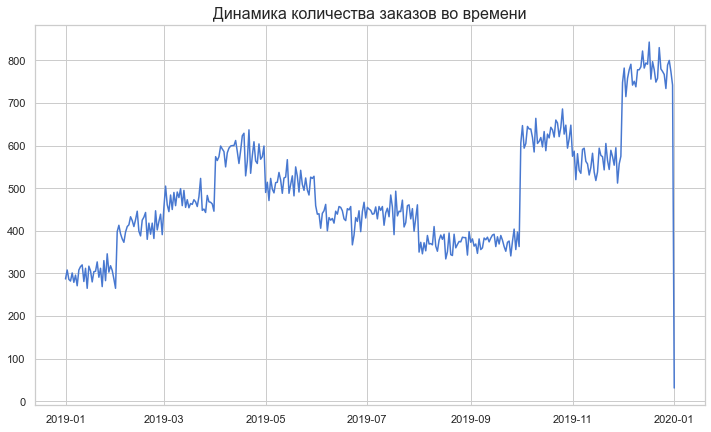

In [26]:
plt.figure(figsize=(12, 7))
plt.plot(bydays)
plt.title('Динамика количества заказов во времени', fontsize=16);

Кажется, что за 2020-й год у нас практически нет данных, поэтому такое серьезное падение, нужно ограничить данные только 19-м годом

In [27]:
df = df[df['Order Time'].dt.year == 2019]
df.reset_index(drop=True, inplace=True)

2. Динамика выручки по месяцам

In [28]:
df['Order Month'] = df['Order Time'].dt.month
bymonths = df.groupby('Order Month')['GMV'].sum()

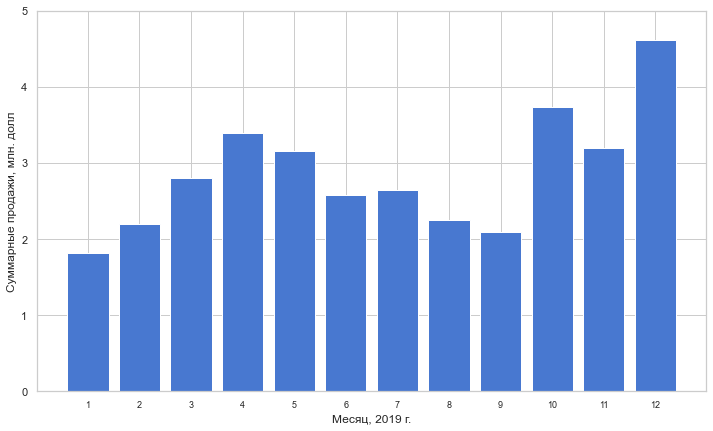

In [29]:
plt.figure(figsize=(12, 7))
plt.bar(x=bymonths.index, height=bymonths.values)

plt.xticks(bymonths.index, size=9)
labels, location = plt.yticks()
plt.yticks(labels, (labels/10**6).astype(int)) # масштабируем на миллионы долл

plt.ylabel('Суммарные продажи, млн. долл', fontsize=12)
plt.xlabel('Месяц, 2019 г.');

По первым двум графикам можем сказать, что 

> - Активность ниже всего в январе, так как посленовогодние праздники + падает летом
> - Активность выше всего в октябре, апреле и в декабре – самые сезонные месяцы для покупки техники. Черная пятница? Новогодние праздники?

3. Динамика кол-ва заказов от времени суток

In [30]:
df['Order Hour'] = df['Order Time'].dt.hour
byhours = df.groupby('Order Hour')['Order ID'].nunique()

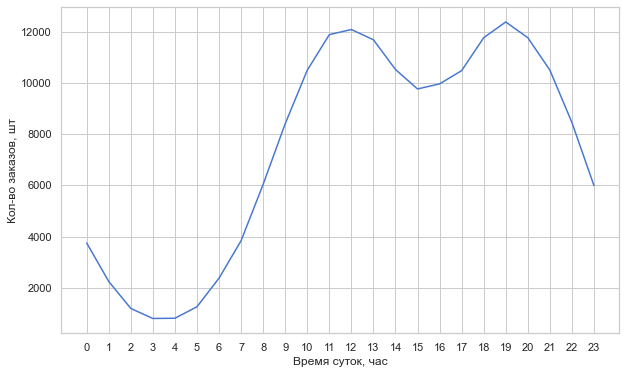

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(byhours)
plt.xticks(byhours.index)
plt.xlabel('Время суток, час', fontsize=12)
plt.ylabel('Кол-во заказов, шт', fontsize=12);

По третьему графику видно, что

> Активность заказов начинает расти с самого утра и достигает пика на обед, а также на ранний вечер. Это часы свободного времени пользователей. Скорее всего пользователи вечером возвращаются домой с работы и у них есть время на заказы, либо в обеденное время. 

Что дальше? – Да что угодно! Можно закапываться в данные сколь угодно, пока не достигнете желаемых результатов, главное соблюдать баланс и не анализировать ради анализа.

Например, мы можем посмотреть, в каком городе больше всего заказов и сказать, что баннеры запускать лучше там. Сгенерируйте собственную гипотезу и проверьте ее:

In [32]:
## Ваш код

### Кейс №2: Доверительный интервал для среднего чека

Предположим, что вы хотите понять, а сколько денег вы в среднем получаете с одного сделанного заказа. При этом вы хотите не только получить точечную оценку, посчитав среднее по выборке, но и построить для этого среднего доверительный интервал.

**Попытка №1**

Мы уже знаем, что доверительный интервал для среднего можно построить из ЦПТ:

$$ 
\bar x \overset{asy}{\sim} N \left(\mu, \frac{\hat{\sigma}^2}{n}\right).
$$ 

$$
\bar x_n \pm z_{1 - \frac{\alpha}{2}} \cdot \frac{\hat \sigma}{\sqrt{n}}
$$

Давайте сделаем это

In [34]:
# считаем, сколько заработали с каждого заказа
# при этом еще отберем user id для каждого заказа (позже будет видно зачем) 
#        – так как связка Order ID – User ID уникальна, можно тупо использовать максимум
byorders = df.groupby('Order ID').agg({'GMV': 'sum', 'User ID': 'max'})

In [47]:
# строим доверительный интервал
mean_hat, std_hat, n = byorders['GMV'].mean(), byorders['GMV'].std(), byorders.shape[0]
alpha = 0.05

left, right = sts.norm.interval(1 - alpha, loc=mean_hat, scale=std_hat/np.sqrt(n))

delta = right - left
print(f"Среднее по выборке: {mean_hat:.4}")
print(f"Доверительный интервал [{left:.4}, {right:.4}] ширины {delta:.4}")

Среднее по выборке: 193.3
Доверительный интервал [191.7, 194.9] ширины 3.167


> Однако, такой доверительный интервал не совсем корректный. Дело в том, что ЦПТ требует _независимость наблюдений_, но эта предпосылка в данном случае перестает быть верной. И вот почему...

**Попытка №2**

Каждый заказ относится к определенному пользователю. При этом есть пользователи, которые склонны тратить больше на площадке, а есть пользователи, которые меньше. Соответственно, если к нам приходит пользователь, готовый тратить много, то средний чек каждого его заказа будет зависимым между собой. Чтобы учесть это, перед тем как строить доверительный интервал для среднего чека, мы можем усреднить этот средний чек для каждого пользователя, а затем уже считать среднее по всей выборке. 

При этом усреднять можно более умно, используя идею _перевзвешивания_. В данном случае мы не будем ее использовать, но про нее можно посмотреть, например, [здесь](https://www.youtube.com/watch?v=z8CqaOQgYcI).

In [49]:
# усредняем данные для каждого пользователя
byusers = byorders.groupby('User ID')['GMV'].mean()

In [51]:
# строим доверительный интервал
mean_hat, std_hat, n = byusers.mean(), byusers.std(), byusers.shape[0]
alpha = 0.05

left, right = sts.norm.interval(1 - alpha, loc=mean_hat, scale=std_hat/np.sqrt(n))

delta = right - left
print(f"Среднее по выборке: {mean_hat:.4}")
print(f"Доверительный интервал [{left:.4}, {right:.4}] ширины {delta:.4}")

Среднее по выборке: 193.4
Доверительный интервал [191.6, 195.2] ширины 3.685


### Кейс №3: Рекомендации товаров

Теперь предположим, что мы хотим повысить средний чек заказа. Для этого, на этапе того, как пользователь добавляет товар в корзину, мы хотим предлагать ему купить еще товары, которые скорее всего его заинтересуют, учитывая тот товар, который он уже добавил в корзину.

**Как нам определить, какие товары рекомендовать конкретному пользователю?**

_Одно из возможных решений_ – посмотреть, какие товары пользователи покупают вместе чаще всего. Их и рекомендовать.

In [32]:
df_orders = df.groupby('Order ID')['Product'].apply(list).reset_index()
df_orders['Product Counts'] = df_orders['Product'].apply(len)

In [33]:
# отбираем заказы, в котором было больше одного товара
df_orders = df_orders[df_orders['Product Counts'] > 1].reset_index(drop=True)

In [34]:
df_orders.head()

,Order ID,Product,Product Counts
0,141275,"[USB-C Charging Cable, Wired Headphones]",2
1,141290,"[Apple Airpods Headphones, AA Batteries (4-pack)]",2
2,141365,"[Vareebadd Phone, Wired Headphones]",2
3,141384,"[Google Phone, USB-C Charging Cable]",2
4,141450,"[Google Phone, Bose SoundSport Headphones]",2


In [35]:
from itertools import combinations
from collections import Counter

count = Counter()

In [36]:
for row in df_orders['Product']:
    count.update(Counter(combinations(row, 2)))

In [37]:
count.most_common(10)

[(('iPhone', 'Lightning Charging Cable'), 1004),
 (('Google Phone', 'USB-C Charging Cable'), 987),
 (('iPhone', 'Wired Headphones'), 447),
 (('Google Phone', 'Wired Headphones'), 414),
 (('Vareebadd Phone', 'USB-C Charging Cable'), 361),
 (('iPhone', 'Apple Airpods Headphones'), 359),
 (('Google Phone', 'Bose SoundSport Headphones'), 220),
 (('USB-C Charging Cable', 'Wired Headphones'), 160),
 (('Vareebadd Phone', 'Wired Headphones'), 143),
 (('Lightning Charging Cable', 'Wired Headphones'), 92)]

Что дальше? – Да снова что угодно! 

Например, если у нас были бы данные о пользователях, то мы могли бы использовать признаки пользователей в составлении рекомендаций (кол-во его заказов в целом, возраст, ...). Кстати, обычно данные разбросаны в куче таблиц, поэтому вполне возможна такая ситуация, когда информация по товарам лежит в одной таблице, а информация по пользователям в другой таблице. Тогда вам нужно будет воспользоваться еще одним очень полезным приемом – __сджойнить 2 таблицы по ключу__. В pandas это можно сделать с помощью функции `pd.merge` 

### Небольшая история про джойны

Часто хранить информацию в одной таблице бывает довольно неудобно. Когда у вас очень крупная IT-компания, данных настолько много, что если их добавить в одну таблицу, работать с ней будет очень неэффективно по времени и памяти. Поэтому информацию кладут в кучу разных таблиц, а над ними строят специальные *отношения* - так называемые колонки, по которым можно эти таблицы объединять. 

Пример устройства такой структуры хранения данных:

<img src="https://progi.pro/media/main/82/d3/34/82d334f5b4b49d424a2460e796a30cd5.png" height="200" width="600"> 

<img src="https://community.qlik.com/legacyfs/online/87693_all-joins.png" height="400" width="400">

In [38]:
df1 = pd.DataFrame({'Student': ['Tom', 'Ujin', 'Ann', 'Polina','Sam'],
                    'group': ['01', '02', '02', '01','02']})
df2 = pd.DataFrame({'Name': ['Tom', 'Ujin', 'Ann', 'Polina', 'Kit'],
                    'GPA': ['7.8', '6.4', '8.3', '9', '10']})
display(df1, df2)

,Student,group
0,Tom,01
1,Ujin,02
2,Ann,02
3,Polina,01
4,Sam,02


,Name,GPA
0,Tom,7.8
1,Ujin,6.4
2,Ann,8.3
3,Polina,9
4,Kit,10


In [39]:
# inner join по умолчанию 
pd.merge(df1, df2, left_on='Student', right_on='Name')

,Student,group,Name,GPA
0,Tom,01,Tom,7.8
1,Ujin,02,Ujin,6.4
2,Ann,02,Ann,8.3
3,Polina,01,Polina,9


In [40]:
# left join - оставляем все, что в левой таблице
pd.merge(df1, df2, left_on='Student', right_on='Name', how='left')

,Student,group,Name,GPA
0,Tom,01,Tom,7.8
1,Ujin,02,Ujin,6.4
2,Ann,02,Ann,8.3
3,Polina,01,Polina,9
4,Sam,02,NaN,NaN


In [41]:
# outer join
pd.merge(df1, df2, left_on='Student', right_on='Name', how='outer')

,Student,group,Name,GPA
0,Tom,01,Tom,7.8
1,Ujin,02,Ujin,6.4
2,Ann,02,Ann,8.3
3,Polina,01,Polina,9
4,Sam,02,NaN,NaN
5,NaN,NaN,Kit,10
